In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import featureman.gen_data as man
from sklearn.cluster import SpectralClustering
import pickle
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
sae_dict = torch.load("sae_model_small_batch_2025-08-07_00-27-27.pth", map_location=device)
sae = man.BatchedSAE_Updated(input_dim=512, n_models=5, width_ratio=4).to(device)
sae.load_state_dict(sae_dict)

<All keys matched successfully>

In [3]:
decoder = sae.W_d[3]

#decoder normalize
decoder = decoder / decoder.norm(dim=1, keepdim=True)

all_sims = decoder @ decoder.T

all_sims.fill_diagonal_(0)  # Set diagonal to zero
#normalize all_sims
all_sims = torch.clamp(all_sims, -1, 1)
all_sims = 1 - torch.arccos(all_sims) / np.pi
all_sims = all_sims.detach().cpu().numpy()

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_eigenspectrum(similarity_matrix, n_eigenvalues=200):
    """
    Analyze the eigenvalue spectrum of a similarity matrix to find natural clustering structure.
    
    Args:
        similarity_matrix: NxN similarity matrix (cosine similarities between SAE features)
        n_eigenvalues: Number of top eigenvalues to examine
    """
    
    # Compute eigenvalues (using eigh for symmetric matrices is more stable)
    # Note: For spectral clustering, we typically look at the Laplacian's eigenvalues
    # But examining the similarity matrix directly can also be informative
    
    print("Computing eigenvalues...")
    eigenvalues = np.linalg.eigvalsh(similarity_matrix)
    
    # Sort in descending order
    eigenvalues = eigenvalues[::-1]
    
    # Create figure with multiple subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle('Eigenvalue Spectrum Analysis for Spectral Clustering', fontsize=14)
    
    # 1. Full spectrum (log scale)
    ax = axes[0, 0]
    ax.semilogy(eigenvalues[eigenvalues > 0], 'b-', linewidth=0.5)
    ax.set_xlabel('Index')
    ax.set_ylabel('Eigenvalue (log scale)')
    ax.set_title('Full Eigenvalue Spectrum')
    ax.grid(True, alpha=0.3)
    
    # 2. Top eigenvalues (linear scale)
    ax = axes[0, 1]
    top_n = min(n_eigenvalues, len(eigenvalues))
    ax.plot(eigenvalues[:top_n], 'b-', linewidth=1)
    ax.set_xlabel('Index')
    ax.set_ylabel('Eigenvalue')
    ax.set_title(f'Top {top_n} Eigenvalues')
    ax.grid(True, alpha=0.3)
    
    # 3. Eigenvalue gaps (to find natural cutoffs)
    ax = axes[0, 2]
    gaps = np.diff(eigenvalues[:top_n])
    ax.plot(-gaps, 'r-', linewidth=1)  # Negative because gaps are negative
    ax.set_xlabel('Index')
    ax.set_ylabel('Eigenvalue Gap')
    ax.set_title('Gaps Between Consecutive Eigenvalues')
    ax.grid(True, alpha=0.3)
    
    # 4. Zoom on potential elbow region (eigenvalues 50-150)
    ax = axes[1, 0]
    start, end = 50, min(150, len(eigenvalues))
    ax.plot(range(start, end), eigenvalues[start:end], 'b-', linewidth=1)
    ax.set_xlabel('Index')
    ax.set_ylabel('Eigenvalue')
    ax.set_title(f'Eigenvalues {start}-{end} (Potential Elbow Region)')
    ax.grid(True, alpha=0.3)
    
    # 5. Normalized eigenvalue curve (to see the decay rate)
    ax = axes[1, 1]
    normalized = eigenvalues[:top_n] / eigenvalues[0]
    ax.plot(normalized, 'g-', linewidth=1)
    ax.set_xlabel('Index')
    ax.set_ylabel('Normalized Eigenvalue')
    ax.set_title('Normalized Eigenvalue Decay')
    ax.grid(True, alpha=0.3)
    
    # 6. Cumulative explained variance
    ax = axes[1, 2]
    cumsum = np.cumsum(eigenvalues[eigenvalues > 0])
    cumsum = cumsum / cumsum[-1]
    ax.plot(cumsum[:top_n], 'purple', linewidth=1)
    ax.set_xlabel('Index')
    ax.set_ylabel('Cumulative Proportion')
    ax.set_title('Cumulative Eigenvalue Proportion')
    ax.axhline(y=0.9, color='r', linestyle='--', alpha=0.5, label='90%')
    ax.axhline(y=0.95, color='orange', linestyle='--', alpha=0.5, label='95%')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Find potential cluster numbers based on gaps
    print("\nLargest eigenvalue gaps (potential cluster numbers):")
    gap_indices = np.argsort(gaps[:min(1500, len(gaps))])[::-1][:10]
    for i in gap_indices:
        print(f"  After eigenvalue {i+1}: gap = {-gaps[i]:.6f} (consider n_clusters≈{i+1})")
    
    # Find where cumulative variance reaches certain thresholds
    print("\nCumulative variance thresholds:")
    thresholds = [0.5, 0.8, 0.9, 0.95, 0.99]
    for thresh in thresholds:
        idx = np.where(cumsum >= thresh)[0][0] if any(cumsum >= thresh) else -1
        if idx >= 0:
            print(f"  {thresh*100:.0f}% variance explained by first {idx+1} eigenvalues")
    
    return eigenvalues

# Usage:
# eigenvalues = analyze_eigenspectrum(similarity_matrix, n_eigenvalues=200)

# For the spectral clustering Laplacian (which is what sklearn actually uses):
def analyze_laplacian_spectrum(similarity_matrix, n_clusters_to_test=[500, 800, 1000, 1200]):
    """
    Analyze the graph Laplacian spectrum which is what spectral clustering actually uses.
    """
    from scipy.sparse import csgraph
    
    # Compute normalized Laplacian (this is what sklearn's spectral clustering uses)
    laplacian = csgraph.laplacian(similarity_matrix, normed=True)
    
    print("Computing Laplacian eigenvalues...")
    laplacian_eigenvalues = np.linalg.eigvalsh(laplacian)
    
    # The smallest eigenvalues of the Laplacian are most important for clustering
    # (In contrast to the similarity matrix where largest eigenvalues matter)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(laplacian_eigenvalues[:100], 'b-')
    plt.xlabel('Index')
    plt.ylabel('Laplacian Eigenvalue')
    plt.title('Smallest 100 Laplacian Eigenvalues')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    # Focus on the region around our cluster numbers of interest
    max_k = max(n_clusters_to_test) + 100
    plt.plot(laplacian_eigenvalues[:min(max_k, len(laplacian_eigenvalues))], 'b-')
    for k in n_clusters_to_test:
        if k < len(laplacian_eigenvalues):
            plt.axvline(x=k, color='r', linestyle='--', alpha=0.5, label=f'k={k}')
    plt.xlabel('Index')
    plt.ylabel('Laplacian Eigenvalue')
    plt.title('Laplacian Eigenvalues (with test cluster numbers)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    # Eigengap - looking for large jumps
    gaps = np.diff(laplacian_eigenvalues[:min(1500, len(laplacian_eigenvalues))])
    plt.plot(gaps[:min(1500, len(gaps))], 'g-', linewidth=0.5)
    plt.xlabel('Index')
    plt.ylabel('Eigengap')
    plt.title('Gaps in Laplacian Spectrum')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Find largest gaps
    print("\nLargest Laplacian eigengaps:")
    gap_indices = np.argsort(gaps[:min(1500, len(gaps))])[::-1][:10]
    for i in gap_indices:
        print(f"  After eigenvalue {i}: gap = {gaps[i]:.6f} (consider n_clusters≈{i})")
    
    return laplacian_eigenvalues

Computing eigenvalues...


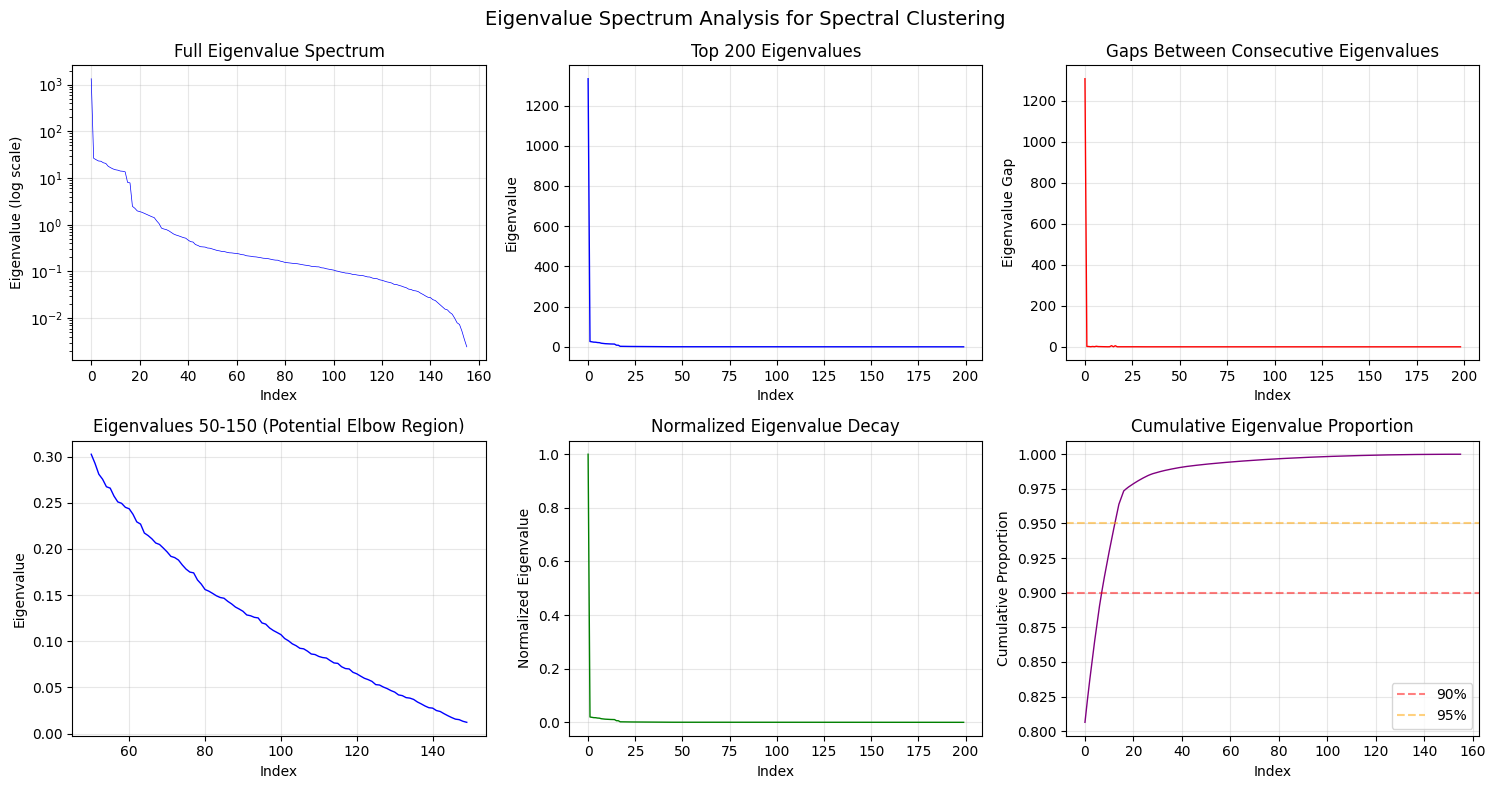


Largest eigenvalue gaps (potential cluster numbers):
  After eigenvalue 165: gap = 0.000192 (consider n_clusters≈165)
  After eigenvalue 177: gap = 0.000356 (consider n_clusters≈177)
  After eigenvalue 126: gap = 0.000458 (consider n_clusters≈126)
  After eigenvalue 118: gap = 0.000459 (consider n_clusters≈118)
  After eigenvalue 140: gap = 0.000460 (consider n_clusters≈140)
  After eigenvalue 198: gap = 0.000471 (consider n_clusters≈198)
  After eigenvalue 115: gap = 0.000483 (consider n_clusters≈115)
  After eigenvalue 112: gap = 0.000527 (consider n_clusters≈112)
  After eigenvalue 134: gap = 0.000538 (consider n_clusters≈134)
  After eigenvalue 162: gap = 0.000550 (consider n_clusters≈162)

Cumulative variance thresholds:
  50% variance explained by first 1 eigenvalues
  80% variance explained by first 1 eigenvalues
  90% variance explained by first 8 eigenvalues
  95% variance explained by first 14 eigenvalues
  99% variance explained by first 39 eigenvalues


array([ 1.3332405e+03,  2.6450693e+01,  2.4641472e+01, ...,
       -4.3209118e-01, -4.3378067e-01, -4.3597135e-01], dtype=float32)

In [5]:
analyze_eigenspectrum(all_sims, n_eigenvalues=200)

Computing Laplacian eigenvalues...


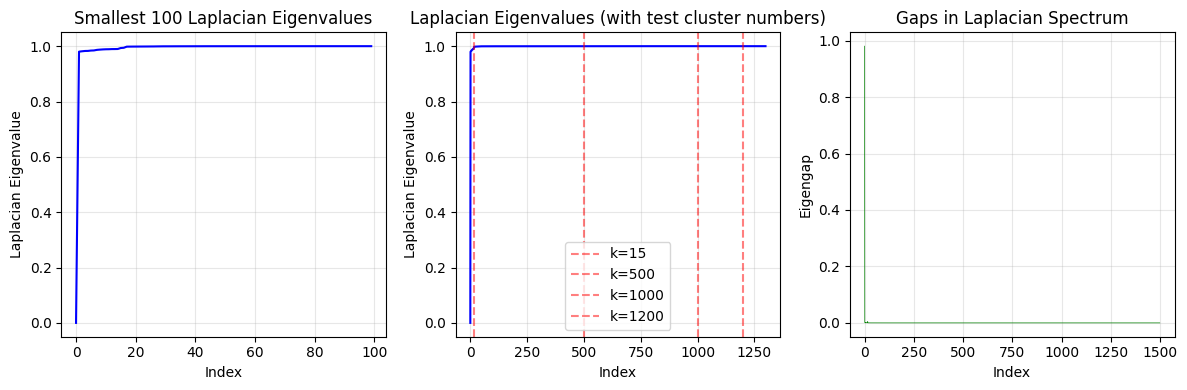


Largest Laplacian eigengaps:
  After eigenvalue 0: gap = 0.980425 (consider n_clusters≈0)
  After eigenvalue 16: gap = 0.004052 (consider n_clusters≈16)
  After eigenvalue 14: gap = 0.003524 (consider n_clusters≈14)
  After eigenvalue 6: gap = 0.002030 (consider n_clusters≈6)
  After eigenvalue 1: gap = 0.001379 (consider n_clusters≈1)
  After eigenvalue 4: gap = 0.001253 (consider n_clusters≈4)
  After eigenvalue 2: gap = 0.001123 (consider n_clusters≈2)
  After eigenvalue 7: gap = 0.000923 (consider n_clusters≈7)
  After eigenvalue 15: gap = 0.000833 (consider n_clusters≈15)
  After eigenvalue 8: gap = 0.000762 (consider n_clusters≈8)


array([1.2334349e-08, 9.8042500e-01, 9.8180401e-01, ..., 1.0007707e+00,
       1.0007721e+00, 1.0007775e+00], dtype=float32)

In [6]:
analyze_laplacian_spectrum(all_sims, n_clusters_to_test=[15, 500, 1000, 1200])

In [7]:
def compare_cluster_structures(similarity_matrix, n_clusters_list=[8, 15, 150, 1000]):
    """
    Compare how cluster structure changes with different n_clusters
    """
    results = {}
    
    for n in n_clusters_list:
        clustering = SpectralClustering(n_clusters=n, affinity='precomputed', random_state=42)
        labels = clustering.fit_predict(similarity_matrix)
        
        # Get cluster sizes
        unique, counts = np.unique(labels, return_counts=True)
        
        results[n] = {
            'labels': labels,
            'sizes': counts,
            'min_size': counts.min(),
            'max_size': counts.max(),
            'median_size': np.median(counts)
        }
        
        print(f"\nn_clusters={n}:")
        print(f"  Cluster sizes: min={counts.min()}, max={counts.max()}, median={np.median(counts):.0f}")
        print(f"  Number of tiny clusters (<5 features): {sum(counts < 5)}")
        print(f"  Number of large clusters (>50 features): {sum(counts > 50)}")
    
    return results

results = compare_cluster_structures(all_sims)


n_clusters=8:
  Cluster sizes: min=211, max=278, median=262
  Number of tiny clusters (<5 features): 0
  Number of large clusters (>50 features): 8

n_clusters=15:
  Cluster sizes: min=101, max=198, median=137
  Number of tiny clusters (<5 features): 0
  Number of large clusters (>50 features): 15

n_clusters=150:
  Cluster sizes: min=1, max=59, median=13
  Number of tiny clusters (<5 features): 49
  Number of large clusters (>50 features): 1

n_clusters=1000:
  Cluster sizes: min=1, max=84, median=1
  Number of tiny clusters (<5 features): 881
  Number of large clusters (>50 features): 2
